In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import os
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset, random_split
from torchvision.utils import make_grid
import torchvision
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from PIL import Image
from torchvision.io import read_image
from torch import nn
from tqdm import tqdm
import pickle 
import shutil
import cv2

In [2]:
import albumentations as A
test_transform = A.Compose([A.Resize(255,255)])

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# path = '/content/drive/MyDrive/mydata/train'

# classes = os.listdir(path)
# data_info = []
# for i in range(len(classes)):
#   temp_add = path+'/'+ classes[i]
#   list_img = os.listdir(temp_add)
#   for j in list_img:
#     tmp = []
#     tmp.append(temp_add+'/'+j)
#     if i == 0:
#       tmp.append(np.array([1, 0, 0]))
#     if i == 1:
#       tmp.append(np.array([0, 1, 0]))
#       # data_info.append(tmp)
#     if i == 2:
#       tmp.append(np.array([0, 0, 1]))
#     data_info.append(tmp)

    



In [5]:
 !pip3 install openslide-python


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 338.7/338.7 KB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for openslide-python: filename=openslide_python-1.2.0-cp38-cp38-linux_x86_64.whl size=28239 sha256=09373dc707eba22aa3013c4f778bfb3b4adf2c09f7aba22d39b049a669daa136
  Stored in directory: /root/.cache/pip/wheels/ae/74/4e/f8654d229eb249d1345e3df0191030ad77e7a6a2114df7cd28
Successfully built openslide-python


In [ ]:
# open_slide('/content/drive/MyDrive/TCGA-18-5592-01Z-00-DX1.41BD6380-A3A0-4ED1-8752-42BBC3B4680C.svs')

NameError: ignored

In [ ]:
# os.listdir('/content/drive/MyDrive/mydata/test')

['TCGA-SKCM', 'TCGA-LUSC', 'TCGA-COAD']

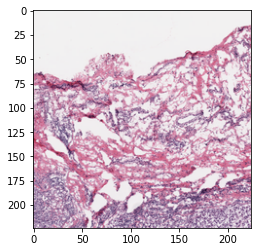

In [12]:
x = np.array(Image.open('/content/drive/MyDrive/project/mydata/test/TCGA-SKCM/TCGA-D3-A2J7-06A-01-TS1.9D75E364-40D3-4583-B697-928937114D63_11_1.tiff'))
plt.imshow(x)

In [ ]:
# import rasterio

In [ ]:
# pth = '/content/drive/MyDrive/mydata/test/TCGA-SKCM/TCGA-D3-A2J7-06A-01-TS1.9D75E364-40D3-4583-B697-928937114D63_11_1.tiff'
# # y = cv2.imread(pth)
# # y = cv2.cvtColor(y, cv2.COLOR_BGR2RGB)
# # # convert_tensor = transforms.Compose(
# #         # [transforms.Resize(255 )])
# # test_transform = A.Compose([A.Resize(255,255,3)])
# # y = test_transform(image = y)
# # y = y["image"] 
# # img = torch.Tensor(y)

# # # img = convert_tensor(img)


# # img.shape



/usr/local/lib/python3.8/dist-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


(4, 224, 224)

In [9]:
from osgeo import gdal

In [10]:
# Dataset generation class


class dataset_gen(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    classes = os.listdir(path)
    data_info = []
    for i in range(len(classes)):
      temp_add = path+'/'+ classes[i]
      list_img = os.listdir(temp_add)
      for j in list_img:
        tmp = []
        tmp.append(temp_add+'/'+j)
        if i == 0:
          tmp.append(np.array([1, 0, 0]))
        if i == 1:
          tmp.append(np.array([0, 1, 0]))
        if i == 2:
          tmp.append(np.array([0, 0, 1]))

        data_info.append(tmp)

    self.data_info = data_info
  def __len__(self):
    return len(self.data_info)
  def __getitem__(self, idx):

    img_path = self.data_info[idx][0]
    label = self.data_info[idx][1]

    img_data = gdal.Open(img_path)
    band1 = img_data.GetRasterBand(1) # Red channel
    band2 = img_data.GetRasterBand(2) # Green channel
    band3 = img_data.GetRasterBand(3) # Blue channel

    b1 = band1.ReadAsArray()
    b2 = band2.ReadAsArray()
    b3 = band3.ReadAsArray()

    img = np.dstack((b1, b2, b3))
    
    img_size = 255
    img = Image.fromarray(img)
    img = img.resize((img_size, img_size))
    img = np.array(img)
    
    img = torch.Tensor(img/255)
    img = torch.permute(img, (2,1,0))

    # img = convert_tensor(img)

    label=label.astype(np.uint8)
    label = torch.Tensor(label)

    return (img, label)


In [13]:
train_path = "/content/drive/MyDrive/project/mydata/train"
val_path = "/content/drive/MyDrive/project/mydata/validation"
test_path = '/content/drive/MyDrive/project/mydata/test'

train_set = dataset_gen(train_path)
val_set = dataset_gen(val_path)
test_set = dataset_gen(test_path)


# train_set, test_set = random_split(data_set, [9000, 810], generator=torch.Generator().manual_seed(0) )

In [15]:
class densenet201(nn.Module):

    def __init__(self, n_classes):
        super().__init__()
        basemodel = torchvision.models.densenet201(weights="IMAGENET1K_V1")
        
        self.base_model = basemodel
        basemodel.classifier = nn.Sequential( 
            nn.Linear(in_features=1920, out_features=3, bias=True),
            nn.Softmax(dim = 1))
        # self.sigm = nn.Sigmoid()
    def forward(self, x):
              return self.base_model(x)

 

# Initialize the model
model = densenet201(3)
# Switch model to the training mode

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#Verifying CUDA
print(device)

#Move the resnet model to GPU for speed if available
model.to(device)
# model2.to(device)

cpu


densenet201(
  (base_model): DenseNet(
    (features): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu1): ReLU(inplace=True)
          (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu2): ReLU(inplace=True)
          (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        )
        (denselayer2): _DenseLayer(
          (norm1): BatchNorm2d(96, eps=1e-05, momen

In [16]:
def training(data_loader, model, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for images, labels in tqdm(data_loader):
    images = images.to(device)
    labels = labels.to(device)

    optimizer.zero_grad()

    model_out = model(images)
    loss = criterion(model_out, labels.type(torch.float))
    loss.backward()
    optimizer.step()

    total_loss += loss.item()

  return total_loss / len(data_loader)

In [17]:
def testing(data_loader, model, criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for images, labels in tqdm(data_loader):
      images = images.to(device)
      labels = labels.to(device)
      model_out = model(images)
      loss = criterion(model_out, labels.type(torch.float))

      total_loss += loss.item()

  return total_loss / len(data_loader)

In [20]:
criterion = nn.BCELoss()
batch_size = 32
epochs = 10
learning_rate = 0.00001
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

train_loader = DataLoader(train_set, batch_size = batch_size,  shuffle = True)
val_loader = DataLoader(val_set, batch_size = batch_size)
test_loader= DataLoader(test_set, batch_size = batch_size)

In [ ]:
len(train_set)

4181

In [ ]:
best_valid_loss = np.Inf
train_loss_of_all_epochs = []
valid_loss_of_all_epochs= []
model_save_limit=0
for i in range(epochs):
  model_save_limit+=1

  train_loss = training(train_loader, model, optimizer, criterion )
  val_loss = testing(val_loader, model, criterion)

  if val_loss < best_valid_loss:
    torch.save(model.state_dict(), '/content/drive/MyDrive/prohect/Best_model1.pt')
    best_valid_loss = val_loss
    print('Model Saved!')
  
  train_loss_of_all_epochs.append(train_loss)
  valid_loss_of_all_epochs.append(val_loss)


    

 
  print(f'Epochs: {i} Train_loss: {train_loss} Validation_loss: {val_loss}')
  

 50%|████▉     | 65/131 [46:34<46:55, 42.66s/it]

In [ ]:
plt.plot(train_loss_of_all_epochs)

NameError: ignored

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/project/FinalProject/Best_model1.pt"))


<All keys matched successfully>

In [ ]:
label_list = os.listdir('/content/drive/MyDrive/mydata/train')

In [ ]:
a = np.array(raw_pred1)
b = np.zeros_like(a)
b[a.argmax(0)] = 1

b

array([0., 1., 0.], dtype=float32)

In [ ]:
model.eval()
transform = torchvision.transforms.ToPILImage()
GT_labels =[]
pred_labels = []
testloader = DataLoader(test_set, batch_size = 1)

for test_img, test_labels in testloader:
    # predicted= ""
    # test_img, test_labels = test_set[sample_id]
    test_img = test_img.to(device, dtype=torch.float)
    test_lables=test_labels.to(device, dtype=torch.float)
    with torch.no_grad():
        raw_pred = model(test_img).cpu().numpy()[0]
        prob = raw_pred
        raw_pred = np.array(raw_pred > 0.5, dtype=float)
        pred_labels.append(raw_pred)
        GT_labels.append(np.array(test_labels)[0])
    
    prob = np.array(prob)[np.argwhere(raw_pred > 0)[:, 0]]
    predicted_labels = np.array(label_list)[np.argwhere(raw_pred > 0)[:, 0]]
    if not len(predicted_labels):
        predicted_labels = ['no predictions']

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

conf_mat= multilabel_confusion_matrix(GT_labels,pred_labels)
x = len(test_set)
accuracies = []
for i in range(len(conf_mat)):
  accuracy = (conf_mat[i][0][0] +conf_mat[i][1][1])/x
  accuracies.append(accuracy)
avg_acc = sum(accuracies)/len(accuracies)
print("Average Accuracies: " + "{:.2f}".format(avg_acc*100)+"%" )
print("Classwise-accuracies")
for i in range(len(label_list)):
  print(label_list[i] + " : " + "{:.2f}".format(accuracies[i]*100)+"%")

Average Accuracies: 84.60%
Classwise-accuracies
TCGA-SKCM : 89.90%
TCGA-LUSC : 79.03%
TCGA-COAD : 84.85%


In [ ]:
pred_labels